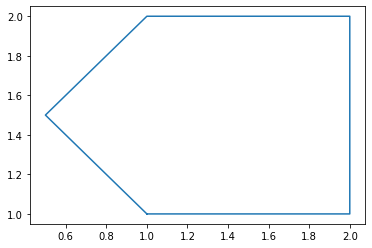

In [1]:
import matplotlib.pyplot as plt

coord = [[1,1], [2,1], [2,2], [1,2], [0.5,1.5]]
coord.append(coord[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coord) #create lists of x and y values

plt.figure()
plt.plot(xs,ys) 
plt.show()

In [1]:
import prestodb
conn=prestodb.dbapi.connect(
    host='localhost',
    port=9000,
    user='python',
    catalog='hive',
    schema='default',
)
cur = conn.cursor()

In [23]:
import json
import math
import shapely
import geopandas
import pandas as pd
from shapely.geometry import LineString, Point, Polygon
cur.execute("""
    with latest_map as (SELECT arbitrary(messagebody) as messagebody, sourcedevice FROM smart_columbus_cve__captcha where messagetype = 'MAP' and os_partition = '2021_01' group by sourcedevice)
    
    select 
        messagebody, json_extract(messageBody, '$.intersections[0].laneWidth') as laneWidth, 
        cast(json_extract_scalar(messageBody, '$.intersections[0].refPoint.lat') as double) / 10000000 as refLat, 
        cast(json_extract_scalar(messageBody, '$.intersections[0].refPoint.long') as double) / 10000000 as refLon,
        
        transform(
               cast(json_extract(messageBody, '$.intersections[0].laneSet') AS ARRAY<JSON>),
                 x -> transform(cast(JSON_EXTRACT(x, '$.nodeList[1]') as ARRAY<JSON>),
                   y -> 
                       cast(
                           row(
                                JSON_EXTRACT_scalar(y, '$.delta[1].x'),
                                JSON_EXTRACT_scalar(y, '$.delta[1].y'),
                                JSON_EXTRACT_scalar(y, '$.attributes.dWidth'),
                                JSON_EXTRACT_scalar(x, '$.laneID'),
                                JSON_EXTRACT_scalar(x, '$.laneAttributes.laneType[0]'),
                                case when JSON_EXTRACT_scalar(x, '$.ingressApproach') = '0' then true else false end,
                                JSON_EXTRACT_scalar(y, '$.delta[0]'),
                                cast(JSON_EXTRACT_scalar(y, '$.delta[1].lat') as double) / 10000000,
                                cast(JSON_EXTRACT_scalar(y, '$.delta[1].lon') as double) / 10000000
                           )
                           as
                           row(
                               x varchar,
                               y varchar,
                               dWidth varchar,
                               laneID varchar,
                               laneType varchar,
                               ingressApproach varchar,
                               offsetType varchar,
                               lat double,
                               lon double
                           )
                       )
                    
                   )
            ) as deltas,
        sourcedevice
    from latest_map
""")
intersections = cur.fetchall()

columns = list(map(lambda x: x[0], cur.description))

df = pd.DataFrame(intersections, columns = columns)

# df.to_csv('warning_data.csv', index=False)
df.describe()

df

messagebody laneWidth     refLat  \
0   {"dataParameters":null,"intersections":[{"id":...       366  39.849061   
1   {"dataParameters":null,"intersections":[{"id":...       366  40.033236   
2   {"dataParameters":null,"intersections":[{"id":...       366  40.059533   
3   {"dataParameters":null,"intersections":[{"id":...       366  40.058806   
4   {"dataParameters":null,"intersections":[{"id":...       366  40.010099   
..                                                ...       ...        ...   
70  {"dataParameters":null,"intersections":[{"id":...       366  40.061480   
71  {"dataParameters":null,"intersections":[{"id":...       366  40.061167   
72  {"dataParameters":null,"intersections":[{"id":...       366  40.056541   
73  {"dataParameters":null,"intersections":[{"id":...       366  40.041149   
74  {"dataParameters":null,"intersections":[{"id":...       366  39.986410   

       refLon                                             deltas  \
0  -82.938288  [[[-1577, 2682, None, 16, vehicle, true, node-...   
1  -83.016286  [[[1868, 454, -122, 49, vehicle, true, node-XY...   
2  -82.953004  [[[583, -2902, -61, 81, vehicle, true, node-XY...   
3  -82.937428  [[[-3682, 410, -122, 118, vehicle, true, node-...   
4  -83.010176  [[[1589, -971, None, 50, vehicle, false, node-...   
..        ...                                                ...   
70 -82.994573  [[[-258, 2780, None, 16, vehicle, true, node-X...   
71 -82.987284  [[[-165, 2459, None, 17, vehicle, true, node-X...   
72 -82.890305  [[[2229, 795, None, 49, vehicle, true, node-XY...   
73 -83.018410  [[[-1895, -357, None, 113, vehicle, true, node...   
74 -82.989094  [[[-4, -2191, -61, 81, vehicle, true, node-XY4...   

              sourcedevice  
0    alumcreek_global_cvcp  
1    high_oaklandpark_cvcp  
2     morse_cleveland_cvcp  
3   morse_westerville_cvcp  
4      high_patterson_cvcp  
..                     ...  
70    morse_evanswood_cvcp  
71        morse_maize_cvcp  
72      morse_stygler_cvcp  
73    high_hollenback_cvcp  
74      cleveland_5th_cvcp  

[75 rows x 6 columns]

In [24]:
df.describe(include='all')

messagebody laneWidth  \
count                                                  75        75   
unique                                                 75         1   
top     {"dataParameters":null,"intersections":[{"id":...       366   
freq                                                    1        75   
mean                                                  NaN       NaN   
std                                                   NaN       NaN   
min                                                   NaN       NaN   
25%                                                   NaN       NaN   
50%                                                   NaN       NaN   
75%                                                   NaN       NaN   
max                                                   NaN       NaN   

           refLat     refLon  \
count   75.000000  75.000000   
unique        NaN        NaN   
top           NaN        NaN   
freq          NaN        NaN   
mean    40.022670 -82.974764   
std      0.052049   0.036139   
min     39.837364 -83.020216   
25%     40.008418 -83.009429   
50%     40.035093 -82.974160   
75%     40.057850 -82.957882   
max     40.062460 -82.890305   

                                                   deltas     sourcedevice  
count                                                  75               75  
unique                                                 75               75  
top     [[[839, 3097, None, 22, vehicle, false, node-X...  high_weber_cvcp  
freq                                                    1                1  
mean                                                  NaN              NaN  
std                                                   NaN              NaN  
min                                                   NaN              NaN  
25%                                                   NaN              NaN  
50%                                                   NaN              NaN  
75%                                                   NaN              NaN  
max                                                   NaN              NaN

In [25]:
geometries = []

for intersection in intersections:
    laneWidth = float(intersection[1])
    ref_lat = float(intersection[2])
    ref_lon = float(intersection[3])
    lanes = intersection[4]
    sourceDevice = intersection[5]
    # lane = lanes[0]

    print(sourceDevice)

    for lane in lanes:
        laneWidth = float(intersection[1])
#         print(lane)
        # print(map['intersections'][0]['laneSet'])

        prevLat = ref_lat
        prevLon = ref_lon
        lane_points = lane

        nextLat = 0
        nextLon = 0

        sizeOfList = len(lane_points)

        if lane_points[0][0] == None:
            print(f"Could not generate lane polygons for {sourceDevice}")
            continue
            
        xAdj = list(map(lambda points: int(points[0]), lane_points))
        yAdj = list(map(lambda points: int(points[1]), lane_points))
        laneWidthAdj = list(map(lambda points: points[2], lane_points))

        laneR = []
        laneL = []
        
        front_lat = None
        front_lon = None
#         print(lane_points)
        for i, point in enumerate(lane_points):
            current_yAdj = yAdj[i]
            current_xAdj = xAdj[i]
            
            nextLat = prevLat + (yAdj[i]/100) / 111111
            nextLon = prevLon + (xAdj[i]/100) / (111111 * math.cos(prevLat * math.pi / 180))
            
            if front_lat == None:
                front_lat = nextLat
                front_lon = nextLon

            if (laneWidthAdj[i]):
                laneWidth = laneWidth + float(laneWidthAdj[i])
#                 print(f"Adjusting lane width by {laneWidthAdj[i]} to {laneWidth}")
            
            if (i < sizeOfList-1):
#                 print(f"{yAdj[i+1]} / {xAdj[i+1]}")
                bearing1 = math.atan2(yAdj[i+1], xAdj[i+1]) + math.pi/2
                bearing2 = math.atan2(yAdj[i+1], xAdj[i+1]) - math.pi/2
            else:
                bearing1 = math.atan2(yAdj[i], xAdj[i]) + math.pi/2
                bearing2 = math.atan2(yAdj[i], xAdj[i]) - math.pi/2

            xAdjR = math.cos(bearing1) * (laneWidth/2)
            yAdjR = math.sin(bearing1) * (laneWidth/2)
            xAdjL = math.cos(bearing2) * (laneWidth/2)
            yAdjL = math.sin(bearing2) * (laneWidth/2)

            laneRY = nextLat + (yAdjR/100) / 111111
            laneRX = nextLon + (xAdjR/100) / (111111 * math.cos(nextLat * math.pi / 180))
            laneR.append((laneRX, laneRY))

            laneLY = nextLat + (yAdjL/100) / 111111
            laneLX = nextLon + (xAdjL/100) / (111111 * math.cos(nextLat * math.pi / 180))
            laneL.append((laneLX, laneLY))

            if (i > 0):
                line1 = LineString(laneR)
                line2 = LineString(laneL)

                if line1.intersects(line2):
                    left = laneL.pop()
                    right = laneR.pop()
                    laneR.append(left)
                    laneL.append(right)

            prevLat = nextLat
            prevLon = nextLon

        laneR.reverse()
    #     print(laneR + laneL)

        coord = laneL + laneR
        geometries.append({'geometry': coord, 'laneID': lane_points[0][3], 'laneType': lane_points[0][4], 'sourceDevice': sourceDevice, 'ingressApproach': lane_points[0][5], 'front_lat': front_lat, 'front_lon': front_lon})
    #     coord.append(coord[0]) #repeat the first point to create a 'closed loop'

    #     xs, ys = zip(*coord) #create lists of x and y values

    #     plt.figure()
    #     plt.plot(xs,ys) 
#         plt.show()

alumcreek_global_cvcp
high_oaklandpark_cvcp
morse_cleveland_cvcp
morse_westerville_cvcp
high_patterson_cvcp
cleveland_elmore_cvcp
high_weber_cvcp
high_13th_cvcp
cleveland_innis_cvcp
high_weisheimer_cvcp
cleveland_hudson_cvcp
high_northbroadway_cvcp
alumcreek_rohr_cvcp
high_morse_cvcp
high_como_cvcp
morse_i270nb_cvcp
columbus_ccu_ecp
cleveland_westerville_cvcp
cleveland_genessee_cvcp
cleveland_huy_cvcp
morse_morsecrossing_cvcp
morse_tamarack_cvcp
high_henderson_cvcp
cleveland_11th_cvcp
high_lane_cvcp
morse_northlandridge_cvcp
high_hudson_cvcp
cleveland_17th_cvcp
high_kelso_cvcp
morse_walford_cvcp
high_dominion_cvcp
alumcreek_groveport_cvcp
alumcreek_toy_cvcp
cleveland_weber_cvcp
high_arcadia_cvcp
morse_mcfadden_cvcp
morse_sandylane_cvcp
high_18th_cvcp
morse_stelzer_cvcp
cleveland_windsor_cvcp
high_woodruff_cvcp
morse_appian_cvcp
high_pacemont_cvcp
high_dodridge_cvcp
morse_chesford_cvcp
morse_sinclair_cvcp
high_olentangy_cvcp
alumcreek_spiegel_cvcp
cleveland_20th_cvcp
high_northwood_cvcp

In [26]:
import plotly.express as px
for lane in geometries:
    lane.update({'geometry': shapely.geometry.Polygon(lane['geometry'])})

geo_df = geopandas.GeoDataFrame(geometries)

fig = px.choropleth_mapbox(geo_df,
                           geojson=geo_df.geometry,
                           locations=geo_df.index,
                           color_continuous_scale="Light24",
                           center={"lat": 40.0633, "lon": -82.9772},
                           color='ingressApproach',
                           opacity=0.75,
                           zoom=14.5)
fig.update_layout(mapbox_style="dark", mapbox_accesstoken="pk.eyJ1Ijoic21ydGNidXMiLCJhIjoiY2ptMTB6YjIzMGVuazNwcWcyczk3a2ZmNSJ9.SjVhquTC7K5RzbGqoGZUYg")
fig.show()

geo_df


geometry laneID   laneType  \
0     POLYGON ((-82.93845 39.84930, -82.93863 39.850...     16    vehicle   
1     POLYGON ((-82.93841 39.84931, -82.93858 39.850...     17    vehicle   
2     POLYGON ((-82.93835 39.84932, -82.93841 39.849...     18    vehicle   
3     POLYGON ((-82.93830 39.84932, -82.93837 39.849...     19    vehicle   
4     POLYGON ((-82.93826 39.84933, -82.93829 39.849...     21    vehicle   
...                                                 ...    ...        ...   
1602  POLYGON ((-82.98933 39.98651, -82.98947 39.986...    117    vehicle   
1603  POLYGON ((-82.98916 39.98654, -82.98888 39.986...     23  crosswalk   
1604  POLYGON ((-82.98885 39.98652, -82.98892 39.986...     55  crosswalk   
1605  POLYGON ((-82.98906 39.98627, -82.98935 39.986...     88  crosswalk   
1606  POLYGON ((-82.98939 39.98633, -82.98927 39.986...    119  crosswalk   

               sourceDevice ingressApproach  front_lat  front_lon  
0     alumcreek_global_cvcp            true  39.849302 -82.938472  
1     alumcreek_global_cvcp            true  39.849308 -82.938430  
2     alumcreek_global_cvcp            true  39.849316 -82.938371  
3     alumcreek_global_cvcp            true  39.849322 -82.938325  
4     alumcreek_global_cvcp           false  39.849327 -82.938282  
...                     ...             ...        ...        ...  
1602     cleveland_5th_cvcp           false  39.986492 -82.989327  
1603     cleveland_5th_cvcp           false  39.986569 -82.989157  
1604     cleveland_5th_cvcp           false  39.986511 -82.988826  
1605     cleveland_5th_cvcp           false  39.986252 -82.989060  
1606     cleveland_5th_cvcp           false  39.986336 -82.989405  

[1607 rows x 7 columns]

In [27]:
geo_df.to_csv("lane_geometries.csv", index=False)

In [28]:
f = open("lane_geometries.geojson", "w")
f.write(json.dumps(geo_df.__geo_interface__))
f.close()

In [29]:
fig = px.scatter_mapbox(geo_df, lat="front_lat", lon="front_lon",     color="laneType", center={"lat": 40.0633, "lon": -82.9772},
                  color_continuous_scale=px.colors.cyclical.IceFire, zoom=14.5)
fig.update_layout(mapbox_style="satellite", mapbox_accesstoken="pk.eyJ1Ijoic21ydGNidXMiLCJhIjoiY2ptMTB6YjIzMGVuazNwcWcyczk3a2ZmNSJ9.SjVhquTC7K5RzbGqoGZUYg")
fig.show()